In [1]:
import glob, h5py, numpy
from pycbc.conversions import mchirp_from_mass1_mass2,chi_eff
from pycbc.sensitivity import volume_montecarlo,volume_to_distance_with_errors
from lal import YRJUL_SI as lal_YRJUL_SI

In [2]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# injection values

In [3]:
with h5py.File(
    '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/injhdf/inj_highspin_mass1p4_dist20_300.hdf','r') as f:
    injm1 = np.ones(len(f['distance'][:]))*1.4
    injm2 = np.ones(len(f['distance'][:]))*1.4
    injdist = f['distance'][:]
    injspin1z = f['spin1z'][:]
    injspin2z = f['spin2z'][:]
    
injmc = mchirp_from_mass1_mass2(injm1,injm2)
injchieff = chi_eff(injm1,injm2,injspin1z,injspin2z)

In [4]:
injm1

array([1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4])

In [5]:
injm2

array([1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4])

In [6]:
injspin1z

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [7]:
injspin2z

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [8]:
injchieff

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

# Found and missed array, size = len(injection)

In [9]:
found_bool = numpy.zeros(len(injm1), dtype=bool)
found_ifarlt_bool = numpy.zeros(len(injm1),dtype=bool)
missed_bool = numpy.zeros(len(injm1), dtype=bool)

In [10]:
num_found = 0 
num_missed = 0

In [12]:
fnames = glob.glob(
    '/work/yifan.wang/search-high-spin/inj-t11-detmass1p4/runs/*/*/HIGHSPIN_coinc/*HDFINJFIND*.hdf')

In [13]:
fnames

['/work/yifan.wang/search-high-spin/inj-t11-detmass1p4/runs/O3b/0/HIGHSPIN_coinc/H1L1V1-HDFINJFIND_HIGHSPIN_INJECTIONS-1253977218-3144122.hdf',
 '/work/yifan.wang/search-high-spin/inj-t11-detmass1p4/runs/O3b/10/HIGHSPIN_coinc/H1L1V1-HDFINJFIND_HIGHSPIN_INJECTIONS-1261261952-321902.hdf',
 '/work/yifan.wang/search-high-spin/inj-t11-detmass1p4/runs/O3b/1/HIGHSPIN_coinc/H1L1V1-HDFINJFIND_HIGHSPIN_INJECTIONS-1257121340-427973.hdf']

In [14]:
len(fnames)

3

In [15]:
loundest_ifar = 1.01 #a constant
t = 0 #foreground time

for fname in fnames:
    f = h5py.File(fname, 'r')
    num_found += len(f['found/ifar_exc'])
    num_missed += len(f['missed/after_vetoes'])#after_vetoes: I think it means some injections are actually 
    #injected to veto times 'by accident', what one really cares about should be those 'within_analysis'
    #There is also an argument named 'within_analysis', which is identical to that of 'after_vetoes'
    
    ifar = f['found/ifar_exc'][:]
    #turn the found and missed indices to True
    injindex = f['found/injection_index'][:]
    injindex_ifarlt = injindex[numpy.where(ifar>=loundest_ifar)[0]]
    
    found_bool[injindex] = True
    found_ifarlt_bool[injindex_ifarlt] = True
    
    missindex = f['missed/after_vetoes'][:] # is this also indices??? Yes it is
    missed_bool[missindex] = True
    
    t += f.attrs['foreground_time_exc'] / lal_YRJUL_SI

In [16]:
found_bool.sum()

6226

In [17]:
found_ifarlt_bool.sum()

3065

In [18]:
num_found

6226

In [19]:
missed_bool.sum()

4381

In [20]:
num_missed

4381

# VT

In [21]:
np.unique(injchieff)

array([-0.9, -0.5, -0.1,  0.1,  0.5,  0.9])

In [22]:
spin = numpy.array([-0.9,-0.5,-0.1,0.1,0.5,0.9])

In [23]:
spin

array([-0.9, -0.5, -0.1,  0.1,  0.5,  0.9])

In [24]:
found_bool ^ found_ifarlt_bool

array([False, False, False, ..., False, False, False])

In [25]:
found_bool & (~found_ifarlt_bool)

array([False, False, False, ..., False, False, False])

In [26]:
np.all(found_bool ^ found_ifarlt_bool == found_bool & (~found_ifarlt_bool))

True

In [27]:
injchieff

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [28]:
unique_chieff = np.unique(injchieff)

In [29]:
unique_chieff

array([-0.9, -0.5, -0.1,  0.1,  0.5,  0.9])

In [30]:
realmissed_bool = (found_bool ^ found_ifarlt_bool) | missed_bool

In [31]:
realmissed_bool

array([False, False, False, ..., False, False, False])

In [32]:
realmissed_bool.sum()

7542

In [33]:
found_bool.sum() - found_ifarlt_bool.sum() + missed_bool.sum()

7542

In [34]:
spin

array([-0.9, -0.5, -0.1,  0.1,  0.5,  0.9])

In [35]:
volume = {}
num_total = 0
num_found = 0
num_missed = 0

for spinv in spin:
    region = np.isclose(injchieff,spinv) 
        
    found_dist = injdist[found_ifarlt_bool & region]
    missed_dist = injdist[realmissed_bool & region]
        
    found_mc = injmc[found_ifarlt_bool & region]
    missed_mc = injmc[realmissed_bool & region]
        
    num_total += region.sum()
    num_found += len(found_dist)
        
    if len(found_dist) == 0:
        print('no injections are found with chieff: ', spinv)
        v=0
        e=0
    else:
        print('found %d injections!!' % len(found_dist))
        v, e = volume_montecarlo(found_dist, missed_dist, 
                                 found_mc, missed_mc, 
                                 'distance', 'uniform', 'distance',20,500)
        volume[spinv] = [v,e]

found 543 injections!!
found 535 injections!!
found 488 injections!!
found 475 injections!!
found 507 injections!!
found 517 injections!!


In [36]:
volume

{-0.9: [51614881.13153308, 3497692.508303703],
 -0.5: [46021873.190570906, 3256492.112439411],
 -0.1: [42041682.5322357, 2989245.90374201],
 0.1: [41964998.087728836, 3030188.5369494273],
 0.5: [50840826.74640959, 3482613.0930052907],
 0.9: [42442256.9377363, 2947646.900272941]}

In [37]:
num_total

1445649

In [38]:
len(injm1)

1445649

In [39]:
num_found

3065

In [40]:
found_ifarlt_bool.sum()

3065

In [41]:
t

0.03359792886658047

# Rate

In [42]:
volume

{-0.9: [51614881.13153308, 3497692.508303703],
 -0.5: [46021873.190570906, 3256492.112439411],
 -0.1: [42041682.5322357, 2989245.90374201],
 0.1: [41964998.087728836, 3030188.5369494273],
 0.5: [50840826.74640959, 3482613.0930052907],
 0.9: [42442256.9377363, 2947646.900272941]}

In [43]:
chieffv = []
rate = []
rate_high = []
rate_low = []

for spinv in volume:
    chieffv.append(spinv)
    rate.append(2.3/t/volume[spinv][0])
    rate_high.append(2.3/t/(volume[spinv][0]-volume[spinv][1]))
    rate_low.append(2.3/t/(volume[spinv][0]+volume[spinv][1]))

In [44]:
chieffv = np.array(chieffv)
rate = np.array(rate)*1e9
rate_high = np.array(rate_high)*1e9
rate_low = np.array(rate_low)*1e9

In [45]:
rate-rate_low

array([ 84.17271448,  98.29802142, 108.09011599, 109.8580069 ,
        86.32184053, 104.74494062])

In [46]:
rate_high-rate

array([ 96.40993287, 113.26838872, 124.63750532, 126.95789654,
        99.01765605, 120.38004117])

In [47]:
error = np.vstack((rate-rate_low,rate_high-rate))

In [48]:
error

array([[ 84.17271448,  98.29802142, 108.09011599, 109.8580069 ,
         86.32184053, 104.74494062],
       [ 96.40993287, 113.26838872, 124.63750532, 126.95789654,
         99.01765605, 120.38004117]])

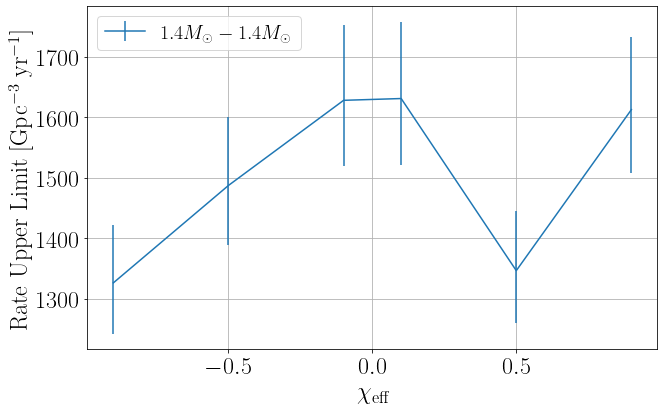

In [49]:
#error = np.array(rate_low, rate_high).T
plt.errorbar(chieffv,rate,yerr=error,fmt='-',label='$1.4M_\odot - 1.4M_\odot$')
plt.xlabel('$\chi_\mathrm{eff}$')
plt.ylabel('Rate Upper Limit [Gpc$^{-3}$ yr$^{-1}$]')
plt.legend(loc='upper left')

In [50]:
volume

{-0.9: [51614881.13153308, 3497692.508303703],
 -0.5: [46021873.190570906, 3256492.112439411],
 -0.1: [42041682.5322357, 2989245.90374201],
 0.1: [41964998.087728836, 3030188.5369494273],
 0.5: [50840826.74640959, 3482613.0930052907],
 0.9: [42442256.9377363, 2947646.900272941]}

# Distance

In [51]:
chieffv = []
dist = []
dist_high = []
dist_low = []

for spinv in volume:
    chieffv.append(spinv)
    d,dhigh,dlow = volume_to_distance_with_errors(volume[spinv][0], volume[spinv][1])
    dist.append(d)
    dist_high.append(dhigh)
    dist_low.append(dlow)

In [52]:
dist,dist_high,dist_low

([230.97347448634767,
  222.30977581063485,
  215.70679515030895,
  215.57556488732465,
  229.81303855846951,
  216.3897176788979],
 [5.1037157546286664,
  5.124488581129384,
  4.9957953047420744,
  5.068618316201622,
  5.131967219629104,
  4.897783383493248],
 [5.339819532415788,
  5.372301787322613,
  5.238584403907254,
  5.318878785102839,
  5.37201822107221,
  5.130140175479028])